Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите агрегированные данные о поездках в мае 2016. Суммируем общее количество поездок такси из каждой географической зоны и считаем количество ячеек, из которых в мае не было совершено ни одной поездки.
2. Рисуем статическую карту Нью-Йорка. Ставим точку там, где находится Эмпайр-Стейт-Билдинг.
3. Поверх статической карты Нью-Йорка визуализируем данные о поездках из каждой ячейки так, чтобы цветовая шкала показывала суммарное количество поездок такси из неё.
4. Вставляем интерактивную карту Нью-Йорка, которую можно прокручивать и увеличивать. Ставим метку там, где находится статуя свободы.
5. Рисуем на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.
6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.
7. Сохранить ноутбук в формате html, html облегчит задачу проверки, в ipynb динамические карты часто не сохраняются.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import folium
import json
import geojson
from folium import plugins
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kirillvolkov/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
with open('data_week1.pkl', 'rb') as file:
    data = pickle.load(file)
#print(data)

In [ ]:
with open('data/regions_week1.pkl', 'rb') as file:
    regions = pickle.load(file)
#print(regions)

In [37]:
ny_coordinates = [[ -74.25559, -73.70001],[40.91553, 40.49612]]
NY_west = ny_coordinates[0][0]
NY_east = ny_coordinates[0][1]
NY_north = ny_coordinates[1][0]
NY_south =  ny_coordinates[1][1]
ESB_long = -73.985664
ESB_lat  =  40.748441
SoL_lat = 40.6892776
SoL_long= -74.0445938

## Загрузка данных и подсчет 0-ых ячеек за май 2016

In [38]:
non_zero = np.count_nonzero( regions.iloc[:,5:] != 0.0)
zero = np.count_nonzero( regions.iloc[:,5:] == 0.0)

regions['count_trips'] = sum(regions.iloc[:, 5:])
summ = []
zero_trips = 0

for i in range(len(regions.count_trips)):
    summ.append(sum(np.array((regions.iloc[i,5:-1]))))
regions['count_trips'] = summ

for i in range(len(regions.count_trips)):
    if regions.count_trips.iloc[i] == 0:
        zero_trips +=1
        
print('Количество ячеек с 0 поездок:', zero_trips)

Количество ячеек с 0 поездок: 2036


Количество поездок на такси по регионам: (для примера регионы с 1225 по 1235)

In [39]:
regions.count_trips[1225:1235]

1225       65.0
1226     2532.0
1227     5031.0
1228     6610.0
1229    10286.0
1230    10366.0
1231    11658.0
1232     8491.0
1233     5629.0
1234     2383.0
Name: count_trips, dtype: float64

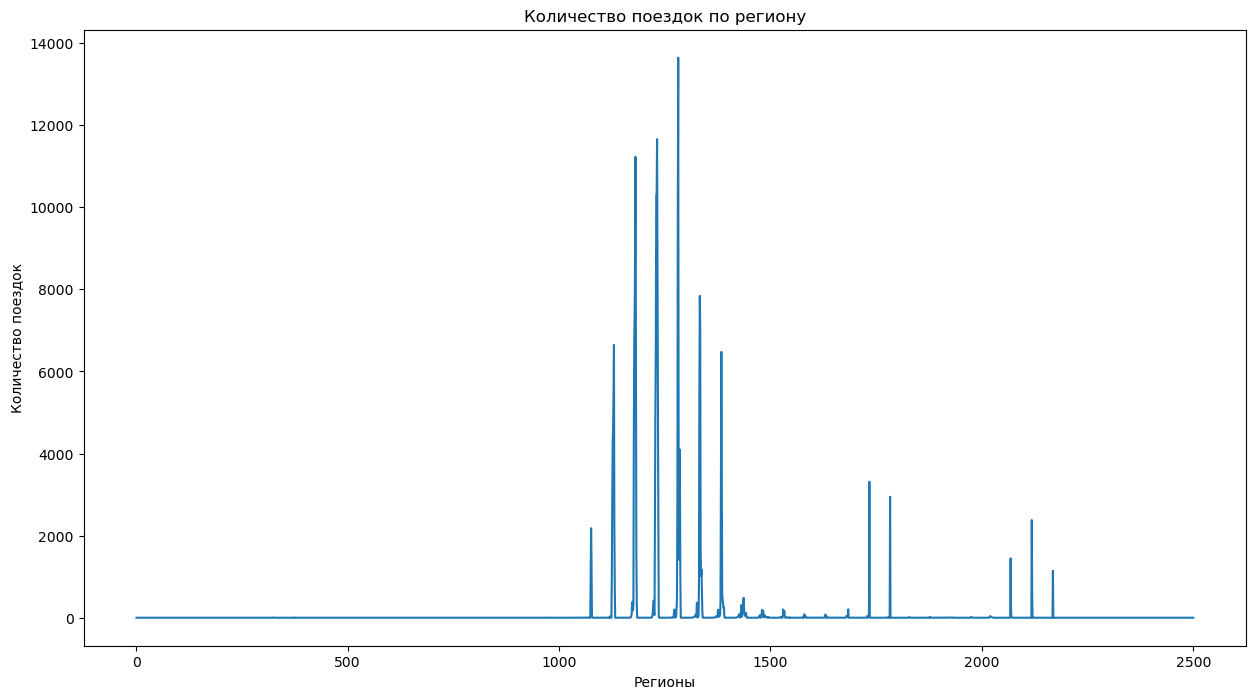

In [40]:
plt.figure(figsize=(15,8))
plt.plot(regions.region, regions.count_trips)
plt.xlabel('Регионы')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по региону')
plt.show()

##  Карта Нью-Йорка

In [42]:
def data2geojson(df):
    '''
    Преобразует координаты датафрейма в мултиполигон формата GeoJson
    '''
    features = []
    insert_features = lambda X: features.append(
        geojson.Feature(geometry = geojson.Polygon([[(X['west'], X['south']),
                                                     (X['east'], X['south']),
                                                     (X['east'], X['north']),
                                                     (X['west'], X['north'])]]),
                        id = str(X.name)))
    
    df.apply(insert_features, axis = 1)
    feature_collection = geojson.FeatureCollection(features)
    dumps = geojson.dumps(feature_collection)
    return geojson.loads(dumps)

In [43]:
regions.iloc[:,1:5]

,west,east,south,north
0,-74.255590,-74.244478,40.496120,40.504508
1,-74.255590,-74.244478,40.504508,40.512896
2,-74.255590,-74.244478,40.512896,40.521285
3,-74.255590,-74.244478,40.521285,40.529673
4,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...
2495,-73.711122,-73.700010,40.873589,40.881977
2496,-73.711122,-73.700010,40.881977,40.890365
2497,-73.711122,-73.700010,40.890365,40.898754
2498,-73.711122,-73.700010,40.898754,40.907142


In [44]:
geo_data = data2geojson(regions.iloc[:,1:5])

In [45]:
longit = np.unique(regions[['west', 'east']].values)
latit  = np.unique(regions[['north', 'south']].values)
long, latt = np.meshgrid(longit, latit)

In [46]:
data_reg_aggr = regions.sum(axis=1)

In [47]:
regions

,region,west,east,south,north,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,...,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00,count_trips
0,1,-74.255590,-74.244478,40.496120,40.504508,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-74.255590,-74.244478,40.504508,40.512896,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,-74.255590,-74.244478,40.512896,40.521285,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,-74.255590,-74.244478,40.521285,40.529673,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,-74.255590,-74.244478,40.529673,40.538061,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,2497,-73.711122,-73.700010,40.881977,40.890365,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,2498,-73.711122,-73.700010,40.890365,40.898754,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2499,-73.711122,-73.700010,40.898754,40.907142,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data_reg_aggr

0        -66.499440
1        -65.482664
2        -64.465887
3        -63.449111
4        -62.432335
           ...     
2495    2430.344435
2496    2431.361211
2497    2432.377987
2498    2433.394764
2499    2434.411540
Length: 2500, dtype: float64

/Users/kirillvolkov/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


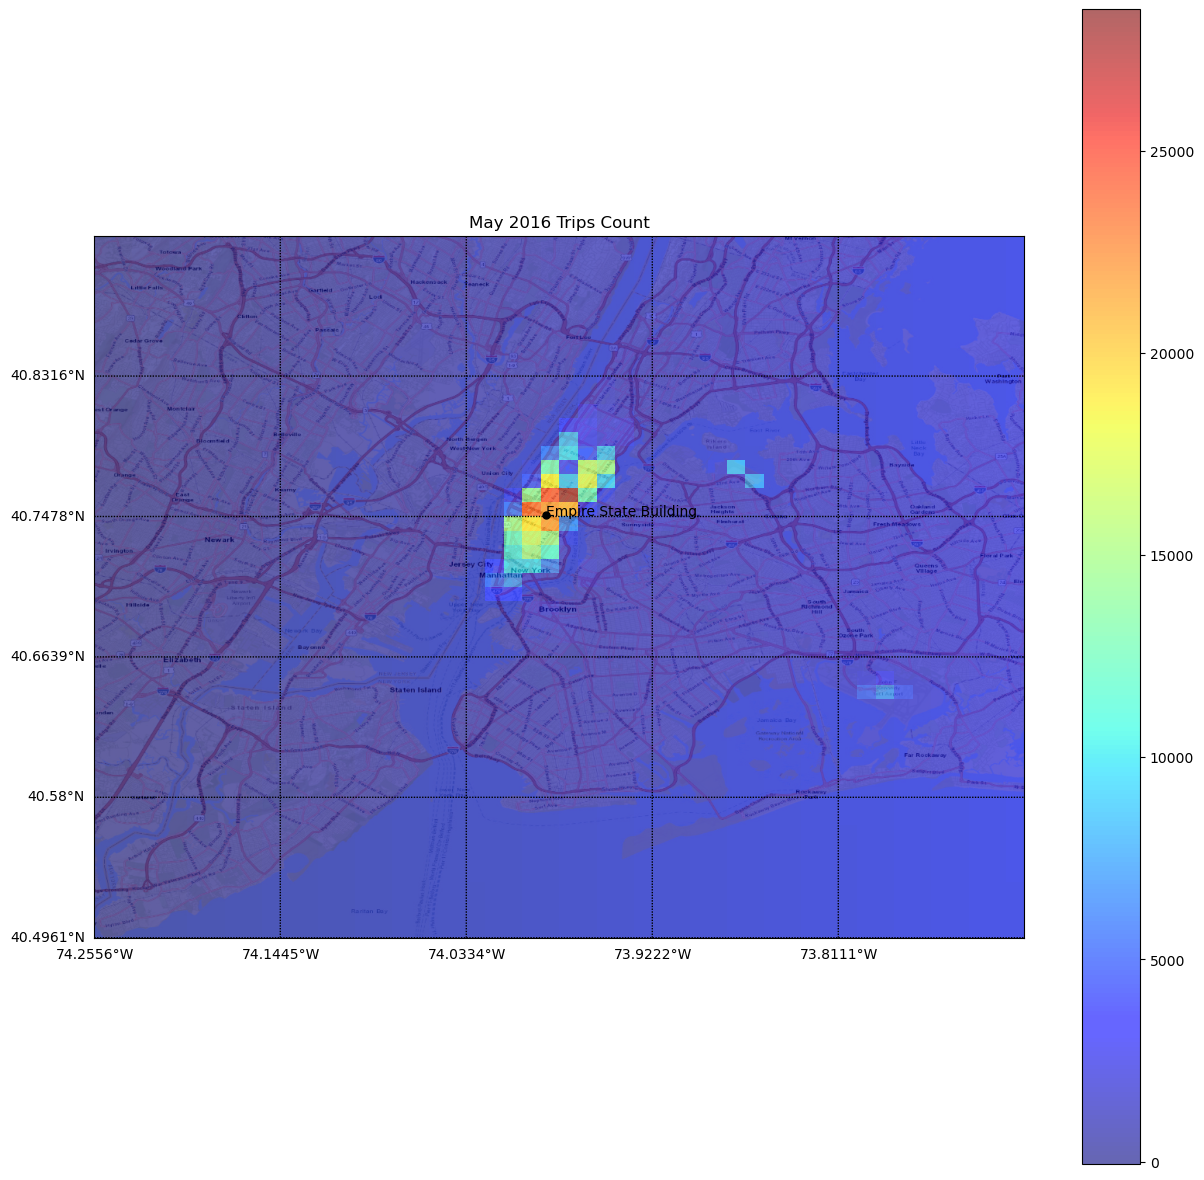

In [51]:
plt.figure(figsize=(15,15))
map_basemap = Basemap(llcrnrlat=(NY_south),
                      llcrnrlon=(NY_west), 
                      urcrnrlat=(NY_north),
                      urcrnrlon=(NY_east), 
                      resolution='f',
                      projection='lcc',
                      area_thresh=5000,
                     lat_0=(NY_north + NY_north)/2.0,
                     lon_0=(NY_west + NY_east)/2.0,
                      epsg=4326)

#Визуализация на карте районы с вызовом такси
map_basemap.pcolormesh(long,
                       latt, 
                       data_reg_aggr.values.reshape(50,50).transpose(), 
                       latlon=True, 
                       cmap='jet',
                       alpha=0.6)

map_basemap.shadedrelief()
map_basemap.bluemarble()
x,y = map_basemap(ESB_long , ESB_lat)
plt.plot(x,y, 'ok', markersize=5)
plt.text(x,y,'Empire State Building', fontsize=10);
map_basemap.arcgisimage(service='World_Street_Map', xpixels=1200, epsg=4326)
plt.colorbar()

parallels = np.arange(NY_south,NY_north, (NY_north - NY_south)/5)
map_basemap.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(NY_west,NY_east, (NY_east - NY_west)/5)
map_basemap.drawmeridians(meridians,labels=[True,False,False,True])

plt.title('May 2016 Trips Count')
plt.show()

Интерактивная карта Нью-Йорка, которую можно прокручивать и увеличивать.

In [52]:
map_folium = folium.Map(location=[SoL_lat, SoL_long], 
                        titles='cartodbpositron')

folium.Marker(location=[SoL_lat, SoL_long],
                 popup='State of Liberty').add_to(map_folium)

folium.Marker(location=[ESB_lat, ESB_long],
                 popup='Empire State Building').add_to(map_folium)
map_folium

Рисуем на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [53]:
#среднее количество поездок за месяц 
mean_trips = []
for i in range(len(regions)):
    mean_trips.append(regions.count_trips[i]/24)
    
regions['mean_trips'] = mean_trips

In [54]:
mm = []
for i in range(len(regions)):
    mm.append(mean(regions.count_trips[i]))

In [60]:
mean = regions.count_trips.mean(axis=0)

In [61]:
feat = []
for i in regions.index:
    poly = geojson.Polygon([[regions.iloc[i].west, regions.iloc[i].south],
                            [regions.iloc[i].west, regions.iloc[i].north],
                            [regions.iloc[i].east, regions.iloc[i].north], 
                            [regions.iloc[i].east, regions.iloc[i].south],
                            [regions.iloc[i].west, regions.iloc[i].south]])
    
    features = geojson.Feature(geometry=poly, 
                               id=str(i), 
                               properties={"name": "region {}".format(int(regions.iloc[i].region))})
    feat.append(features)
feach = geojson.FeatureCollection(feat)   

with open('regions.json', 'w') as file:
    json.dump(feach, file)

In [62]:
print(file)

<_io.TextIOWrapper name='regions.json' mode='w' encoding='UTF-8'>


In [69]:
data_reg_a = regions.sum(axis=1)

In [70]:
(data_reg_a == 0).sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
2495    False
2496    False
2497    False
2498    False
2499    False
Length: 2500, dtype: bool>

In [80]:
from branca.colormap import LinearColormap

vmin = data_reg_a.min()
vmax = data_reg_a.max()
width = vmax-vmin
color = LinearColormap(['white', 'green', 'cyan', 'blue', 'magenta', 'red'],
                        vmax = vmax, vmin = vmin,
                        index=[vmin, 20, 0.3*width, 0.6*width, 0.9*width, 1.0*vmax])
color

In [67]:
regions_left = []
for ind, val in enumerate(mean_trips):
    if val >= 5:
        regions_left.append(int(ind))

In [68]:
len(regions_left)

90

In [71]:
def custom_color_map(value):
    global regions_left
    if value in regions_left:
        return ('#008000')
    else:
        return ('#ff0000')

In [74]:
map_folium2 = folium.Map(location=[SoL_lat, SoL_long], 
                         titles='cartodbpositron', zoom_start=10)
folium.Marker(location=[SoL_lat, SoL_long],
                 popup='State of Liberty').add_to(map_folium2)

folium.Marker(location=[ESB_lat, ESB_long],
                 popup='Empire State Building').add_to(map_folium2)


folium.GeoJson(
    feach,
    style_function=lambda feacher: {
        'fillColor': color(data_reg_a[int(feacher['id'])]),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    }).add_to(map_folium2)

color.caption = 'Mean trips'
map_folium2.add_child(color)
map_folium2

In [93]:
# folium.Marker(location=[SoL_lat, SoL_long],
#                  popup='State of Liberty').add_to(map_folium2)

# folium.Marker(location=[ESB_lat, ESB_long],
#                  popup='Empire State Building').add_to(map_folium2)

# map_folium2 = folium.Map(location = [SoL_lat, SoL_long],
#                          zoom_start = 11, 
#                          control_scale = True,
#                          attr='USGS style')
# folium.Choropleth(
#     geo_data = geo_data,
#     data = mean_trips,
#     columns = ['id', 'value'],
#     key_on = 'id',
#     fill_color = 'BuPu',
#     legend_name = u'Среднее число поездок в час',
#     fill_opacity=0.7,
#     line_opacity=0.2).add_to(map_folium2)

# map_folium2

In [91]:
print('Количество регионов с поездками меньше 5:', (regions.count_trips.values < 5).sum())

Количество регионов с поездками меньше 5: 2264


In [92]:
cnt = 0
for i in regions.mean_trips:
    if i <= 5.:
        cnt +=1
print('Количество поездками меньше 5:', cnt)

Количество поездками меньше 5: 2410



7. Сохраняем ноутбук в формате html, html облегчит задачу проверки — в ipynb динамические карты часто не сохраняются

In [95]:
# !jupyter nbconvert --to html taxi 2.ipynb